In [2]:
import os
import tarfile
import gzip
import shutil
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The following are process to extract data from the tar.gz file and store a csv file locally, it will also automatically create a new data frame called combined df

In [3]:
# This script extracts a tar.gz archive, decompresses .nc.gz files to .nc files, and handles potential errors.
# ----- Step 1: Extract the tar.gz archive -----
tar_path = "Data.tar.gz"  # <-- Update with your tar.gz archive path
extract_folder = "extracted_files"
os.makedirs(extract_folder, exist_ok=True)

print("Extracting tar.gz archive...")
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_folder)
print("Extraction complete.\n")

# ----- Step 2: Decompress each .nc.gz file to .nc files -----
print("Decompressing .nc.gz files...")
for file in os.listdir(extract_folder):
    if file.endswith(".nc.gz"):
        gz_file_path = os.path.join(extract_folder, file)
        nc_file_path = os.path.join(extract_folder, file[:-3])  # Remove the .gz extension
        try:
            # Check if the destination file already exists; if so, remove it
            if os.path.exists(nc_file_path):
                try:
                    os.remove(nc_file_path)
                except PermissionError:
                    print(f"Cannot remove existing file {nc_file_path} - file may be in use by another process")
                    continue
                    
            with gzip.open(gz_file_path, "rb") as f_in, open(nc_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
            print(f"Decompressed {file} to {os.path.basename(nc_file_path)}")
        except PermissionError as e:
            print(f"Permission error with {file}: {str(e)}. The file may be in use by another process.")
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
print("\nDecompression complete.\n")

Extracting tar.gz archive...
Extraction complete.

Decompressing .nc.gz files...
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720110-53983.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720110-53983.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720113-54829.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720113-54829.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720120-63837.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720120-63837.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720137-04867.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720137-04867.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720151-03049.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720151-03049.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720170-63851.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720170-63851.nc
Decompressed hadisd.3.4.2.202502p_19310101-20250301_720172-53996.nc.gz to hadisd.3.4.2.202502p_19310101-20250301_720172-53996.nc
Decompressed had

In [4]:
# ----- Step 3: Inspect available columns in one sample file -----
sample_nc_file = None
for file in os.listdir(extract_folder):
    if file.endswith(".nc"):
        sample_nc_file = os.path.join(extract_folder, file)
        break

if sample_nc_file:
    print("Opening sample file for inspection:", sample_nc_file)
    ds = xr.open_dataset(sample_nc_file)
    
    print("\nAvailable Data Variables:")
    for var in ds.data_vars:
        print(" -", var)
    
    print("\nAvailable Coordinates:")
    for coord in ds.coords:
        print(" -", coord)
    
    # Export the available columns to a text file
    with open("available_columns.txt", "w") as f:
        f.write("Data Variables:\n")
        for var in ds.data_vars:
            f.write(" - " + var + "\n")
        f.write("\nCoordinates:\n")
        for coord in ds.coords:
            f.write(" - " + coord + "\n")
    print("\nAvailable columns exported to 'available_columns.txt'\n")
else:
    print("No .nc file found for inspection.\n")

Opening sample file for inspection: extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720110-53983.nc

Available Data Variables:
 - station_id
 - temperatures
 - dewpoints
 - slp
 - stnlp
 - windspeeds
 - winddirs
 - total_cloud_cover
 - low_cloud_cover
 - mid_cloud_cover
 - high_cloud_cover
 - precip1_depth
 - precip2_depth
 - precip3_depth
 - precip6_depth
 - precip9_depth
 - precip12_depth
 - precip15_depth
 - precip18_depth
 - precip24_depth
 - cloud_base
 - wind_gust
 - past_sigwx1
 - input_station_id
 - quality_control_flags
 - flagged_obs
 - reporting_stats

Available Coordinates:
 - longitude
 - latitude
 - elevation
 - time

Available columns exported to 'available_columns.txt'



In [5]:
# ----- Step 4: Read selected variables from each .nc file and combine them -----
# Based on the available columns, we select a subset of meaningful variables and exclude complex fields 
# like 'quality_control_flags', 'flagged_obs', and 'reporting_stats'.
desired_vars = [
    'station_id',         # Station ID
    'temperatures',       # Temperature
    'dewpoints',          # Dew point
    'slp',                # Sea level pressure
    'stnlp',              # Station level pressure
    'windspeeds',         # Wind speed
    'winddirs',           # Wind direction
    'total_cloud_cover',  # Total cloud cover
    'low_cloud_cover',    # Low cloud cover
    'mid_cloud_cover',    # Mid cloud cover
    'high_cloud_cover',   # High cloud cover
    'precip1_depth',      # 1-hour precipitation depth
    'precip2_depth',      # 2-hour precipitation depth
    'precip3_depth',      # 3-hour precipitation depth
    'precip6_depth',      # 6-hour precipitation depth
    'precip9_depth',      # 9-hour precipitation depth
    'precip12_depth',     # 12-hour precipitation depth
    'precip15_depth',     # 15-hour precipitation depth
    'precip18_depth',     # 18-hour precipitation depth
    'precip24_depth',     # 24-hour precipitation depth
    'cloud_base',         # Cloud base height
    'wind_gust',          # Wind gust
    'past_sigwx1',        # Past significant weather phenomena
    'input_station_id'    # Input station ID
]

# Note: Coordinates (e.g., time, longitude, latitude, elevation) will be included automatically when converted to a DataFrame
nc_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
dfs = []

print("Processing .nc files and extracting desired variables...")
for nc_file in nc_files:
    try:
        # Open the netCDF file with xarray; using chunks enables lazy loading (via dask)
        ds = xr.open_dataset(nc_file, chunks={})
        
        # Filter to only the desired variables that are present in the current file
        available_vars = [var for var in desired_vars if var in ds.data_vars]
        if available_vars:
            ds_subset = ds[available_vars]
            # Convert to a pandas DataFrame; this will also convert coordinates (like time) to columns
            df = ds_subset.to_dataframe().reset_index()
            # Optionally, add a column to record the source file name
            df["source_file"] = os.path.basename(nc_file)
            dfs.append(df)
            print(f"Processed {nc_file} with DataFrame shape {df.shape}")
        else:
            print(f"No desired variables found in {nc_file}")
    except Exception as e:
        print(f"Error processing {nc_file}: {e}")

if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print("\nCombined DataFrame shape:", combined_df.shape)
else:
    combined_df = pd.DataFrame()
    print("\nNo DataFrames were loaded.")

print("\nCombined DataFrame preview:")
print(combined_df.head())

Processing .nc files and extracting desired variables...
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720110-53983.nc with DataFrame shape (177055, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720113-54829.nc with DataFrame shape (175400, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720120-63837.nc with DataFrame shape (158335, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720137-04867.nc with DataFrame shape (181798, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720151-03049.nc with DataFrame shape (182084, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720170-63851.nc with DataFrame shape (171432, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720172-53996.nc with DataFrame shape (173616, 26)
Processed extracted_files\hadisd.3.4.2.202502p_19310101-20250301_720175-53919.nc with DataFrame shape (176462, 26)
Processed extracted_fil

In [6]:
# ----- Step 5: Save the DataFrame to a CSV file (if not empty) -----
if not combined_df.empty:
    output_csv_path = "combined_weather_data.csv"
    combined_df.to_csv(output_csv_path, index=False)
    print(f"\nSaved combined data to {output_csv_path}")
    
    # Generate basic statistics for numerical columns
    print("\nBasic statistics of numerical columns:")
    print(combined_df.describe())
    
    # Check for missing values
    missing_values = combined_df.isnull().sum()
    print("\nMissing values count:")
    print(missing_values)
    
    # If a 'time' column exists, output the time range
    if 'time' in combined_df.columns:
        print("\nTime range in the dataset:")
        print(f"Start: {combined_df['time'].min()}")
        print(f"End: {combined_df['time'].max()}")
else:
    print("\nNo data was successfully extracted.")


Saved combined data to combined_weather_data.csv

Basic statistics of numerical columns:
                                time  temperatures     dewpoints  \
count                       22886565  2.267168e+07  2.257343e+07   
mean   2015-03-01 23:24:28.134395904 -1.260374e+28 -3.230542e+28   
min              1943-01-01 06:00:00 -2.000000e+30 -2.000000e+30   
25%              2010-08-22 19:00:00  6.300000e+00  0.000000e+00   
50%              2015-06-19 12:00:00  1.600000e+01  9.400000e+00   
75%              2020-04-10 00:00:00  2.300000e+01  1.700000e+01   
max              2025-02-28 23:00:00  4.800000e+01  3.310000e+01   
std                              NaN  1.582676e+29  2.521254e+29   

                slp         stnlp    windspeeds      winddirs  \
count  2.004150e+06  1.764485e+07  2.263474e+07  2.239588e+07   
mean  -3.568595e+28 -4.069857e+27 -8.860972e+28  9.405292e+01   
min   -2.000000e+30 -2.000000e+30 -2.000000e+30 -8.880000e+02   
25%    1.012200e+03  9.774000e+02  0.

In [7]:
combined_df.head()

,time,station_id,temperatures,dewpoints,slp,stnlp,windspeeds,winddirs,total_cloud_cover,low_cloud_cover,...,precip9_depth,precip12_depth,precip15_depth,precip18_depth,precip24_depth,cloud_base,wind_gust,past_sigwx1,input_station_id,source_file
0,2004-08-06 21:00:00,b'777777777777',33.0,23.0,NaN,NaN,5.1,80.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1500.0,NaN,NaN,b'720110-99999',hadisd.3.4.2.202502p_19310101-20250301_720110-...
1,2004-08-06 22:00:00,b'777777777777',34.0,23.0,NaN,NaN,4.6,90.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'720110-99999',hadisd.3.4.2.202502p_19310101-20250301_720110-...
2,2004-08-06 23:00:00,b'777777777777',33.0,23.0,NaN,NaN,4.6,70.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'720110-99999',hadisd.3.4.2.202502p_19310101-20250301_720110-...
3,2004-08-07 00:00:00,b'777777777777',31.0,23.0,NaN,NaN,2.6,100.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'720110-99999',hadisd.3.4.2.202502p_19310101-20250301_720110-...
4,2004-08-07 01:00:00,b'777777777777',30.0,22.0,NaN,NaN,2.1,80.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'720110-99999',hadisd.3.4.2.202502p_19310101-20250301_720110-...


Data used as a demo here is aquired from 720000-721999 from the page https://www.metoffice.gov.uk/hadobs/hadisd/v342_202502p/download.html, containing 140 station data

In [8]:
len(combined_df["source_file"].unique())

140

In [9]:
import re

# First cast the byte strings to regular Python strings
combined_df['input_station_id'] = combined_df['input_station_id'].astype(str)

# Extract the first 5 digits from 'input_station_id' and append to the existing 'station' column
combined_df['station'] = combined_df['input_station_id'].str.extract(r'(\d{5})')

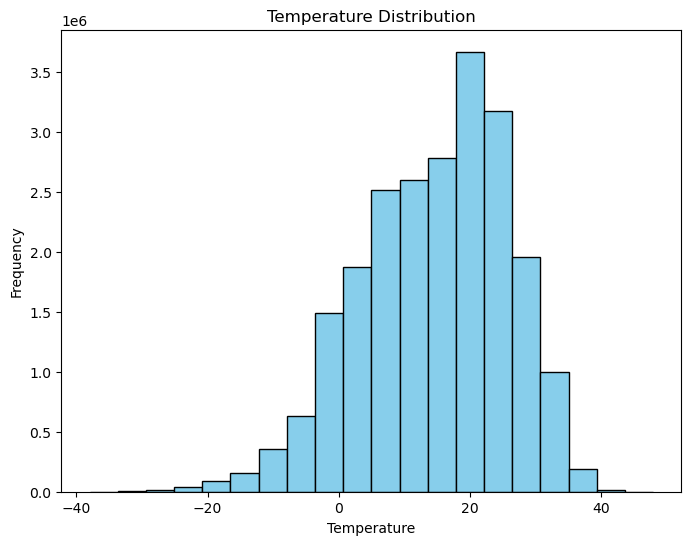

In [11]:
plt.figure(figsize=(8, 6))
temp_data = combined_df['temperatures'].dropna()  # Drop missing values
#print("unrrealistic temp values" + temp_data.min())
temp_data = temp_data[temp_data > -273]  # Filter out unrealistic values, I really hope nowhere in the world has temperatures below absolute zero
plt.hist(temp_data, bins=20, color='skyblue', edgecolor='black')
plt.title("Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

The temperature distribution form the data set

KeyboardInterrupt: 

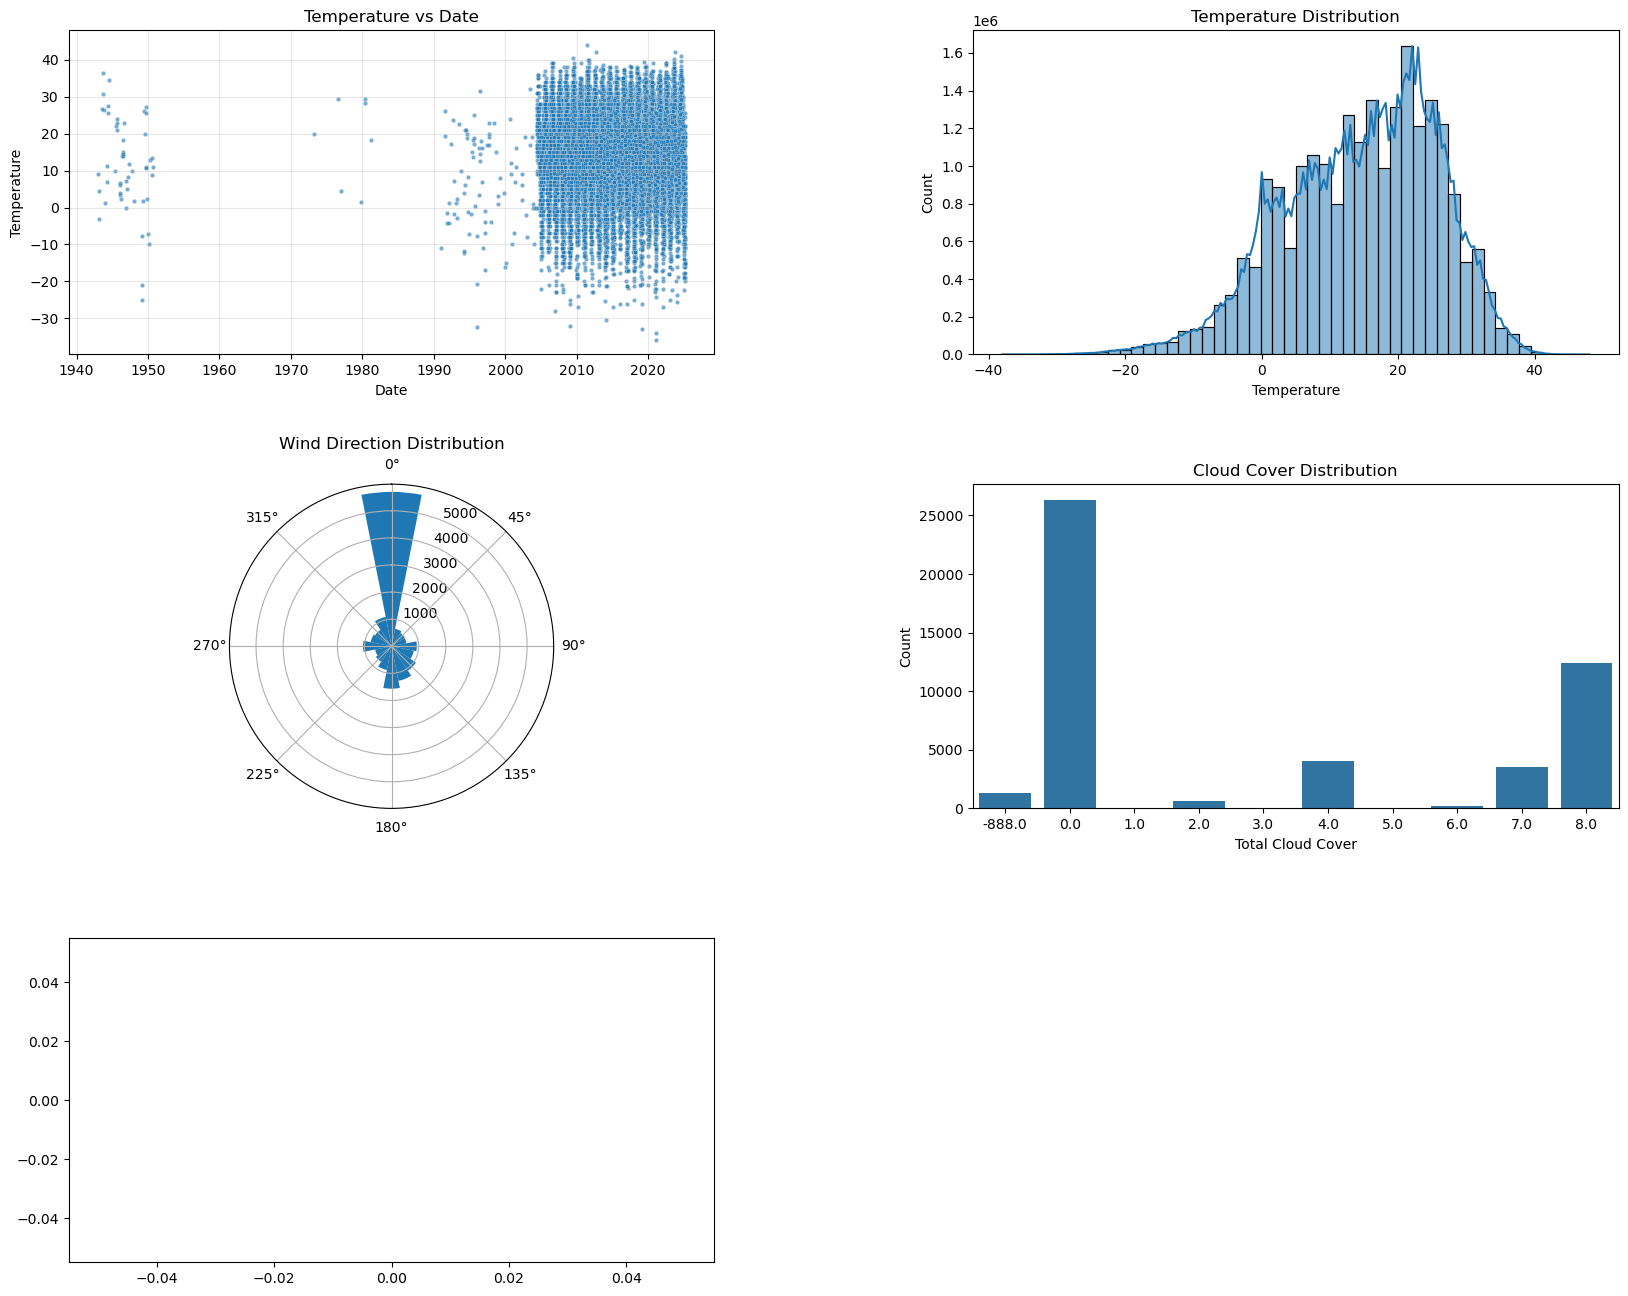

In [12]:
# Create a set of visualizations to explore the weather data

# Set up the figure layout
fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# 1. Scatter plot of date vs temperature
ax1 = plt.subplot(3, 2, 1)
temp_scatter_data = combined_df.dropna(subset=['time', 'temperatures']).sample(20000, random_state=42)
temp_scatter_data = temp_scatter_data[temp_scatter_data['temperatures'] > -273]  # Filter out unrealistic temps
sns.scatterplot(x='time', y='temperatures', data=temp_scatter_data, alpha=0.6, s=10, ax=ax1)
ax1.set_title('Temperature vs Date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature')
ax1.grid(True, alpha=0.3)

# 2. Distribution of temperatures
ax2 = plt.subplot(3, 2, 2)
sns.histplot(combined_df[combined_df['temperatures']> -273]['temperatures'].dropna(), bins=50, kde=True, ax=ax2)
ax2.set_title('Temperature Distribution')
ax2.set_xlabel('Temperature')

# 3. Wind rose (wind direction distribution)
ax4 = plt.subplot(3, 2, 3, polar=True)
wind_sample = combined_df.dropna(subset=['winddirs']).sample(20000, random_state=42)
hist, bins = np.histogram(wind_sample['winddirs'], bins=16, range=(0, 360))
width = 2*np.pi/16
ax4.bar(np.deg2rad(np.arange(0, 360, 22.5)), hist, width=width, bottom=0.0)
ax4.set_title('Wind Direction Distribution')
ax4.set_theta_zero_location("N")
ax4.set_theta_direction(-1)

# 4. Cloud cover distribution
ax5 = plt.subplot(3, 2, 4)
sns.countplot(x='total_cloud_cover', data=combined_df.sample(50000, random_state=42), ax=ax5)
ax5.set_title('Cloud Cover Distribution')
ax5.set_xlabel('Total Cloud Cover')
ax5.set_ylabel('Count')

# 5. Wind speed distribution
ax6 = plt.subplot(3, 2, 5)
sns.histplot(combined_df[combined_df['windspeeds']>= 0]['windspeeds'].dropna(), bins=50, kde=True, ax=ax6)
ax6.set_title('Wind Speed Distribution')
ax6.set_xlabel('Wind Speed')

plt.tight_layout()
plt.savefig('weather_data_visualization.png', dpi=300)
plt.show()



Same here for some analysis for some data

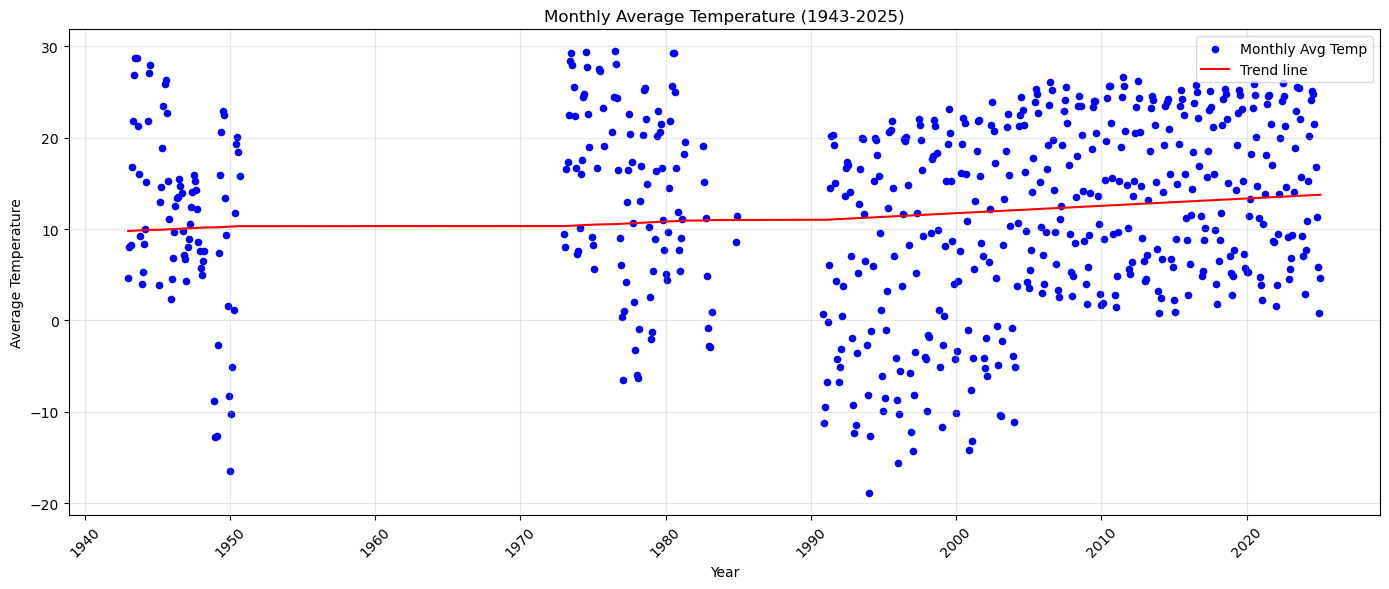

In [ ]:
# 6. Monthly variation of temperature (scatter version)
plt.figure(figsize=(14, 6))

# Filter out extreme temperatures
temp_data = combined_df[combined_df['temperatures'] > -273].copy()

# Add a month column for aggregation
temp_data['month'] = pd.to_datetime(temp_data['time']).dt.to_period('M')

# Group by month and calculate mean temperature
monthly_temps = temp_data.groupby('month')['temperatures'].mean().reset_index()
monthly_temps['month'] = monthly_temps['month'].dt.to_timestamp()

# Scatter plot
plt.scatter(monthly_temps['month'], monthly_temps['temperatures'], color='blue', s=20, label='Monthly Avg Temp')

# Trend line
z = np.polyfit(np.arange(len(monthly_temps)), monthly_temps['temperatures'], 1)
p = np.poly1d(z)
plt.plot(monthly_temps['month'], p(np.arange(len(monthly_temps))), color='red', label='Trend line')

plt.title('Monthly Average Temperature (1943-2025)')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.savefig('monthly_temperature_trend.png', dpi=300)
plt.show()


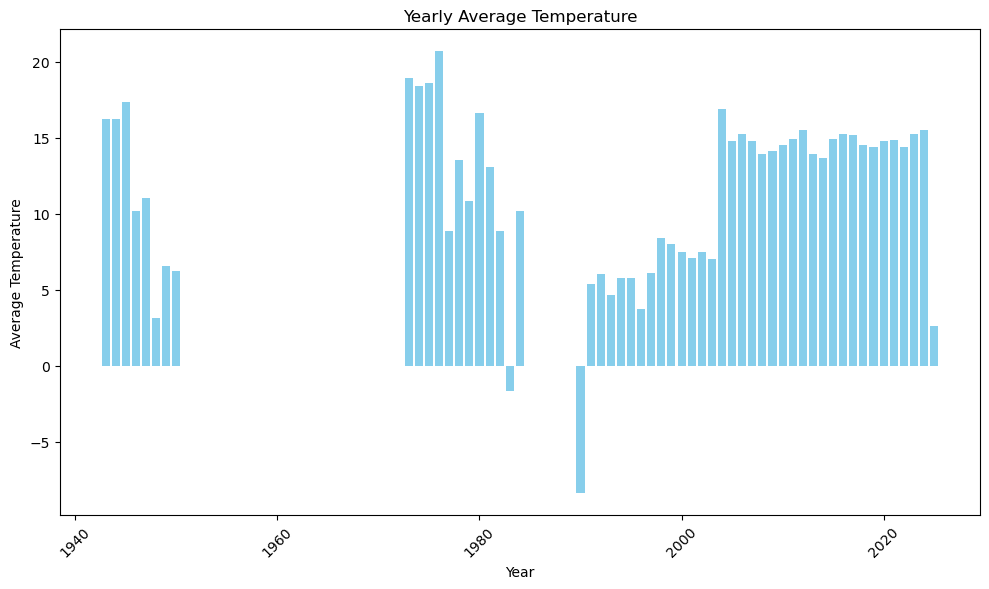

In [ ]:
yearly_avg_temp = temp_data.groupby(temp_data['time'].dt.year)['temperatures'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(yearly_avg_temp['time'], yearly_avg_temp['temperatures'], color='skyblue')
plt.title('Yearly Average Temperature')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('yearly_avg_temperature.png', dpi=300)
plt.show()